In [2]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [4]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [5]:
slices = load_scan('project1/CCM_Data/Benign/045/4')

In [6]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

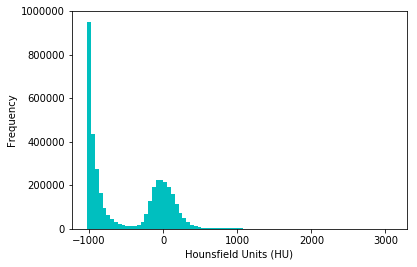

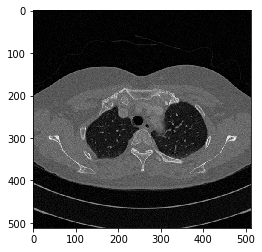

In [9]:
first_patient = slices
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[3], cmap=plt.cm.gray)
plt.show()

In [10]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (15, 512, 512)
Shape after resampling	 (300, 309, 309)


In [29]:
i = 0

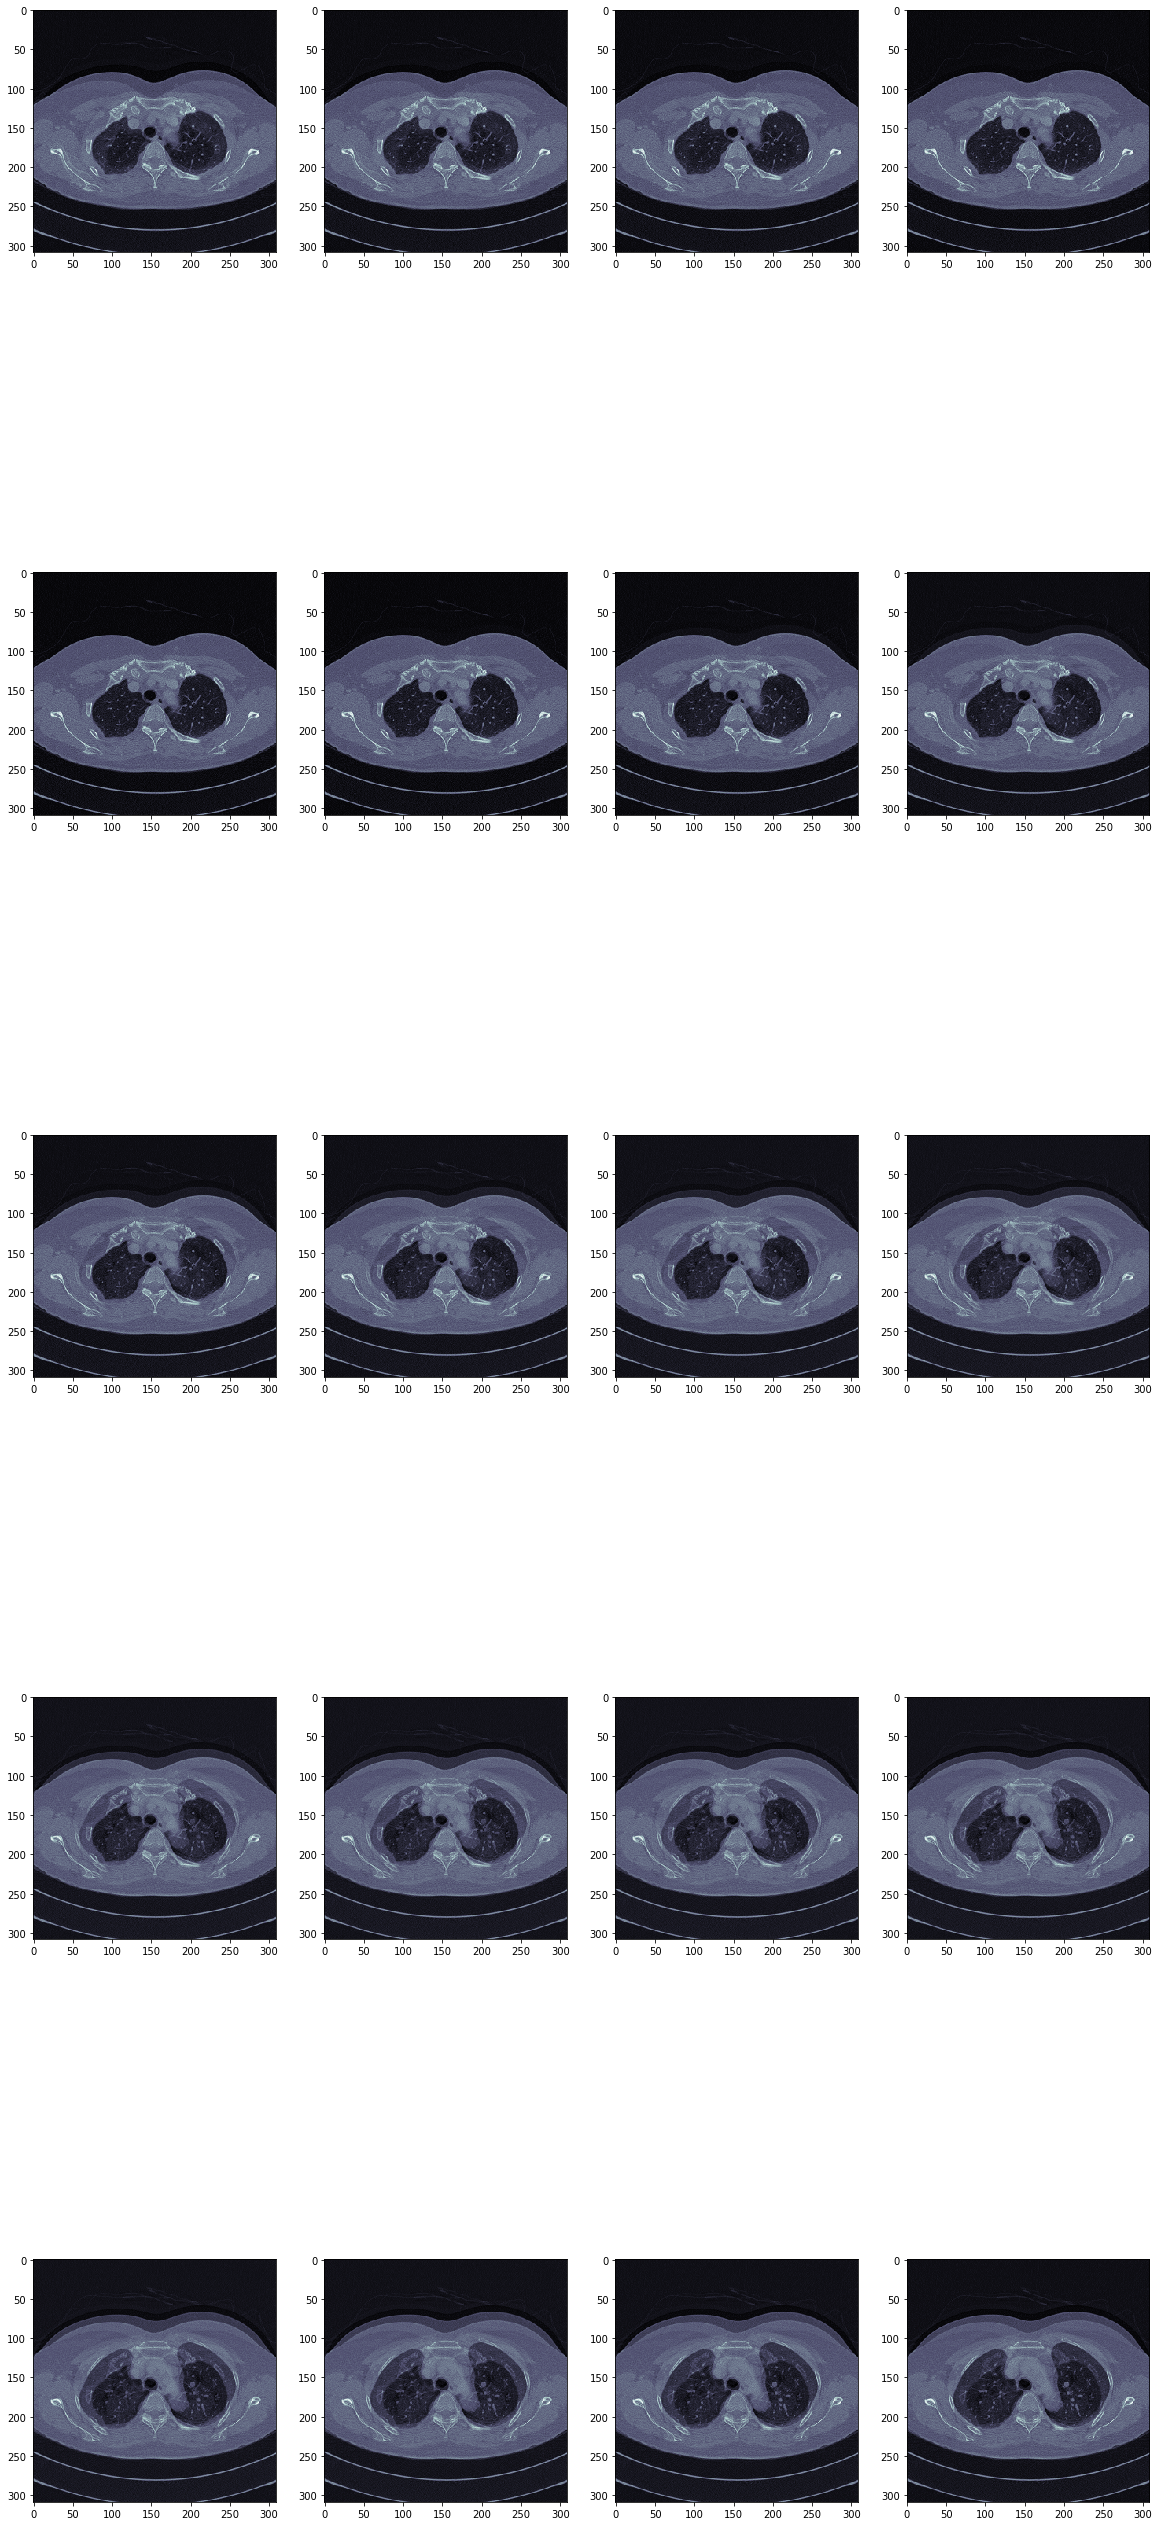

In [33]:
plt.figure(figsize=(20, 50))

for idx, slice in enumerate(pix_resampled[i * 20: i * 20 + 20]):
    plt.subplot(5, 4, idx + 1)
    plt.imshow(slice, plt.cm.bone)
    plt.show
i += 1

In [3]:
df = dicom.read_file(os.path.join('project1/CCM_Data/Benign/045/4', '1.3.12.2.1107.5.1.4.51698.30000008122922075679600023672.dcm'))

In [5]:
df

(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.51698.30000008122922075679600023672
(0008, 0020) Study Date                          DA: '20081230'
(0008, 0021) Series Date                         DA: '20081230'
(0008, 0022) Acquisition Date                    DA: '20081230'
(0008, 0023) Content Date                        DA: '20081230'
(0008, 0030) Study Time                          TM: '123348.093000'
(0008, 0031) Series Time                         TM: '123950.031000'
(0008, 0032) Acquisition Time                    TM: '123856.521304'
(0008, 0033) Content Time                        TM: '123800.0'
(0008, 0050) Accession Number                    SH: 'ANONYMOUS'
(0008, 0060) Modality                            CS: 'CT'
(0008, 1030) Study Description                   LO: 'CT, Chest with E